In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from tqdm import tqdm
from random import randint

Using TensorFlow backend.


In [3]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
ENCODING_DIMENSION = 32
BATCH_SIZE = 256
EPOCHS = 50

In [4]:
def load_data():
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train = x_train / 255.
    x_train = x_train.reshape((x_train.shape[0], np.prod(x_train.shape[1:])))
    x_test = x_test / 255.
    x_test = x_test.reshape((x_test.shape[0], np.prod(x_test.shape[1:])))
    return x_train, x_test

In [5]:
x_train, x_test = load_data()
x_train.shape, x_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 784), (10000, 784))

In [6]:
def build_autoencoder(image_width, image_height, encoding_dimension):
    image_shape = image_width * image_height
    input_placeholder = Input(shape = (image_shape, ))
    encoded = Dense(encoding_dimension, activation = 'relu', name = 'Encoded')(input_placeholder)
    decoded = Dense(image_shape, activation = 'sigmoid', name = 'Decoded')(encoded)
    autoencoder = Model(input_placeholder, decoded, name = 'Autoencoder')
    encoder = Model(input_placeholder, encoded, name = 'Encoder')
    encoded_input = Input(shape = (encoding_dimension, ))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input), name = 'Encoder')
    autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
    return encoder, decoder, autoencoder

In [7]:
encoder, decoder, autoencoder = build_autoencoder(IMAGE_WIDTH, IMAGE_HEIGHT, ENCODING_DIMENSION)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
Encoded (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


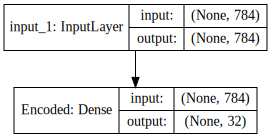

In [9]:
SVG(model_to_dot(encoder, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [10]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
Decoded (Dense)              (None, 784)               25872     
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________


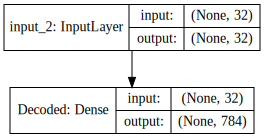

In [11]:
SVG(model_to_dot(decoder, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
Encoded (Dense)              (None, 32)                25120     
_________________________________________________________________
Decoded (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


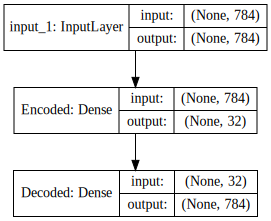

In [13]:
SVG(model_to_dot(autoencoder, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [14]:
history = autoencoder.fit(x_train, x_train, epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle = True, validation_data = (x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 4s 74us/sample - loss: 0.3654 - val_loss: 0.2716
Epoch 2/50
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2649 - val_loss: 0.2550
Epoch 3/50
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2448 - val_loss: 0.2327
Epoch 4/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2245 - val_loss: 0.2143
Epoch 5/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2089 - val_loss: 0.2012
Epoch 6/50
60000/60000 [==============================] - 1s 16us/sample - loss: 0.1977 - val_loss: 0.1918
Epoch 7/50
60000/60000 [==============================] - 1s 16us/sample - loss: 0.1894 - val_loss: 0.1846
Epoch 8/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.1828 - val_loss: 0.1785
Epoch 9/50
60000/60000 [======================

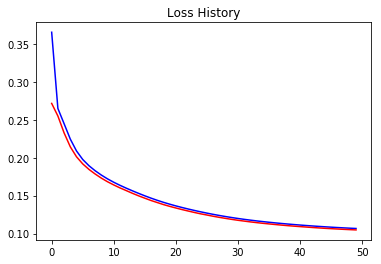

In [15]:
plt.plot(history.history['loss'], color = 'b')
plt.plot(history.history['val_loss'], color = 'r')
plt.title('Loss History')
plt.show()

In [16]:
def plot_images(nrows, figsize, image_width, image_height, encoder, decoder):
    ncols = 3
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.setp(axes.flat, xticks = [], yticks = [])
    index = randint(0, len(x_test) - 1)
    encoded_image = None
    for i, ax in enumerate(axes.flat):
        if i % 3 == 0:
            index = randint(0, len(x_test) - 1)
            ax.imshow(x_test[index].reshape(image_width, image_height), cmap = 'gray')
            ax.set_xlabel('Test_Image_' + str(index))
        elif i % 3 == 1:
            encoded_image = encoder.predict(x_test[index].reshape(1, image_width * image_height))
            ax.imshow(encoded_image.reshape(8, 4), cmap = 'gray')
            ax.set_xlabel('Encoded_Image_' + str(index))
        elif i % 3 == 2:
            ax.imshow(decoder.predict(encoded_image).reshape(image_width, image_height), cmap = 'gray')
            ax.set_xlabel('Decoded_Image_' + str(index))
    plt.show()

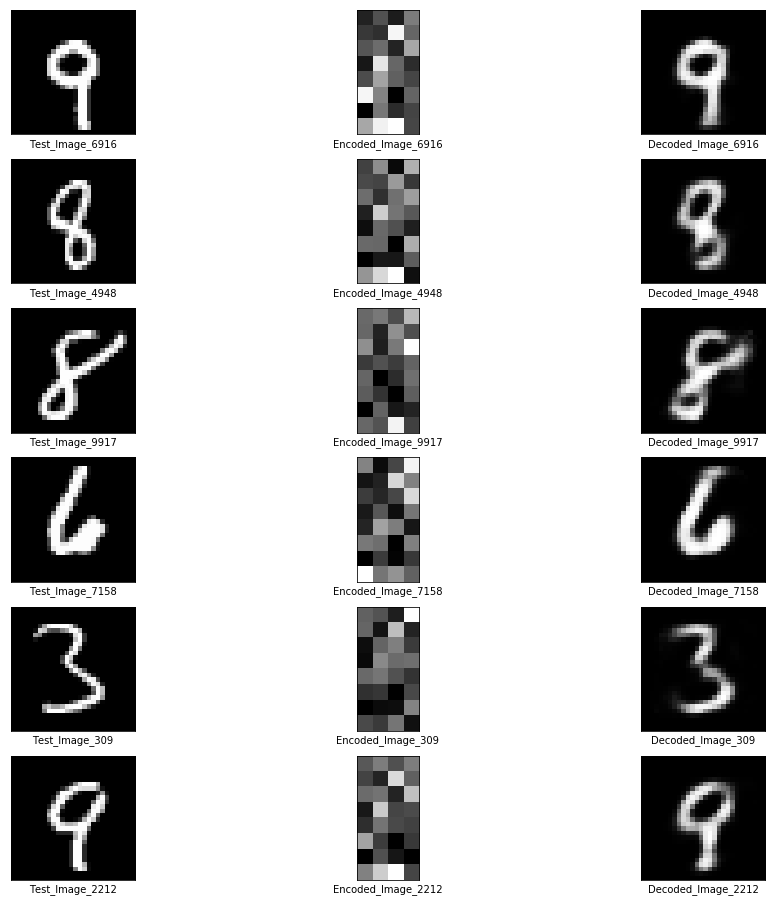

In [17]:
plot_images(6, (16, 16), IMAGE_WIDTH, IMAGE_HEIGHT, encoder, decoder)

In [18]:
encoder.save('./encoder.h5')
decoder.save('./decoder.h5')